In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [3]:
using PotentialFlow

In [4]:
using CairoMakie
#using Plots
#pyplot()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Define some useful plotting functions

In [1022]:
function data_histogram(x::Vector{T};bins=80,xlims = (-2,2), kwargs...) where {T<:Real}
    f = Figure()
    ax1 = f[1, 1] = Axis(f;kwargs...)
    hist!(ax1,x,bins=bins)
    xlims!(ax1, xlims...)
    f
end


function show_vortices!(ax,x::Vector,obs::AbstractObservationOperator;kwargs...)   
    vort_array = state_to_vortex_states(x,obs.config)
    scatter!(ax,vort_array[1,:],vort_array[2,:])
end

function show_vortex_samples!(ax,x_samples::Array,obs::AbstractObservationOperator;kwargs...)   
    vort_array = states_to_vortex_states(x_samples,obs.config)
    scatter!(ax,vort_array[1,:],vort_array[2,:],markersize=1,label="sample")
    
end

"""
    show_vortex_samples(x_samples,obs)

Plot the samples of an ensemble of states as a scatter plot of vortex positions. Note that
`x_samples` must be of size Nstate x Ne.
"""
function show_vortex_samples(x_samples::Array,obs::AbstractObservationOperator;xlims=(-2,2),ylims=(-2,2),kwargs...)
    f = Figure()
    ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
    show_vortex_samples!(ax,x_samples,obs;kwargs...)
    xlims!(ax,xlims...)
    ylims!(ax,ylims...)
    f
end

function plot_vorticity!(ax,μ,Σ,obs::AbstractObservationOperator;xlims = (-2.5,2.5),ylims = (-2.5,2.5))
    xg = range(xlims...,length=201)
    yg = range(ylims...,length=201)
    w = [vorticity(x,y,μ,Σ,obs.config) for x in xg, y in yg]
    contour!(ax,xg,yg,w)
    xlims!(ax,xlims...)
    ylims!(ax,ylims...)
end

function plot_vorticity(μ,Σ,obs::AbstractObservationOperator; kwargs...)
    f = Figure()
    ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
    plot_vorticity!(ax,μ,Σ,obs;kwargs...)
    f
end

function vortex_ellipses!(ax,μ,Σ,obs::AbstractObservationOperator; kwargs...)
    for j = 1:obs.config.Nv
        xidj, yidj, Γidj = get_vortex_ids(j,obs.config)
        μxj = μ[[xidj,yidj]]
        Σxxj = Σ[xidj:yidj,xidj:yidj]
        xell, yell = draw_ellipse(μxj,Σxxj)
        lines!(ax,xell,yell,color=:red,marker=:none)
    end
end

function vortex_ellipses(μ,Σ,obs::AbstractObservationOperator; kwargs...)
    f = Figure()
    ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
    vortex_ellipses!(ax,μ,Σ,obs;kwargs...)
    f
end

function compute_and_plot_pressure_field!(ax,x::Vector,obs::PressureObservations;xlims=(-2.5,2.5),ylims=(-2.5,2.5),kwargs...)
    xg = range(xlims...,length=201)
    yg = range(ylims...,length=201)
    zg = xg .+ im*yg' 
    vort = state_to_lagrange(x,obs.config;isblob=true)
    p = analytical_pressure(zg,vort,obs.config)
    plot_pressure_field!(ax,xg,yg,p,obs;kwargs...)
end

function plot_pressure_field!(ax,xg,yg,p,obs::AbstractObservationOperator; levels = range(-0.5,0.01,length=21), kwargs...)
    contour!(ax,xg,yg,p,levels=levels,colormap=:RdBu)
    plot_sensors!(ax,obs)
end

function plot_sensor_data!(ax,ystar::Vector,x::Vector,t::Real,obs::AbstractObservationOperator; sensor_noise=zero(ystar))
    plot_sensor_data!(ax,ystar,obs;sensor_noise=sensor_noise)
    y_est = observations(x,t,obs)
    scatter!(ax,y_est,markersize=15,color=:transparent,strokewidth=1,label="estimate")
end

function plot_sensor_data!(ax,ystar::Vector,obs::AbstractObservationOperator; sensor_noise=zero(ystar))
    scatter!(ax,ystar,markersize=10,color=:black,label="truth")
    errorbars!(ax,1:length(ystar),ystar,sensor_noise)
    axislegend(ax,position=:rb)
end

function plot_sensors!(ax,obs::PressureObservations)
    scatter!(ax,real.(obs.sens),imag.(obs.sens),marker=:rect,color=:black)
end

plot_sensors! (generic function with 1 method)

### Evaluation grids and sensors

In [1010]:
# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 2.0
Nsens = 3
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
Nsens = 11
ϵsens = 0.0
lowerrow = range(-1.5,1.5,length=Nsens) .+ (-0.5ϵsens .+ ϵsens*rand(Nsens))*im
#upperrow = range(-2.0,2.0,length=Nsens) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=Nsens) .- 1.0
#rightside = im*range(-1.0,3.0,length=Nsens) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

### Truth

In [806]:
Nv_cluster = 3 #3
Nv_per_cluster = 1 #5
Nv_true = Nv_cluster*Nv_per_cluster 
δ_true = 0.1

# For placing the vortices randomly

xr = (-1.5,1.5)
yr = (0.1,1.0)
Γr = (0.0,2.0)


σx = 0.03
σΓ = 0.03
zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)


#zv = [0.0+0.75im]
#Γv = [1.0]
#zv = [0.0+0.75im,0.75+0.5im]
#Γv = [1.2,1.0]
#zv = [-1.0+0.75im,0.25+0.5im,0.75+0.75im]
#Γv = [1.0,1.2,1.4]


config_true = VortexConfig(Nv_true, δ_true,body=LowRankVortex.NoWall)

truez = zv

vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state(vort,config_true);

#=
x_true = [-0.7611581857580003,
  0.7266716391085539,
  0.04730897238217636,
  0.4637373841856715,
  0.6347931827658125,
  1.6466841098688845];
  zv, Γv = state_to_positions_and_strengths(x_true)
  Nv_true =  2
  config_true = VortexConfig(Nv_true, δ_true,body=LowRankVortex.NoWall)  
=#


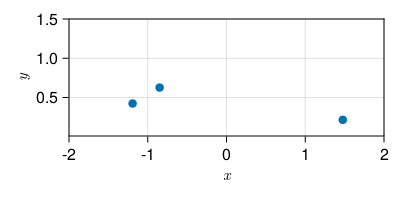

In [1025]:
f = Figure(;resolution = (400, 200))
ax = f[1,1] = Axis(f;limits=(xr,yr), xlabel = L"x",ylabel = L"y", aspect=DataAspect())
show_vortices!(ax,x_true,obs_true)
f

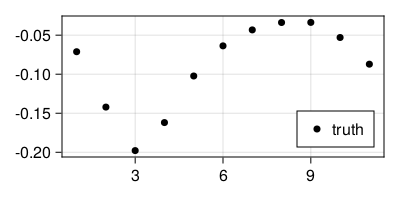

In [1026]:
f = Figure(;resolution = (400, 200))
ax = f[1,1] = Axis(f)
obs_true = PressureObservations(sens,config_true);
ystar = observations(x_true,t,obs_true);
plot_sensor_data!(ax,ystar,obs_true)
f

## Vortex estimation

In [1027]:
Nv_estimator = 3
δ = 0.1

config_estimator = VortexConfig(Nv_estimator, δ, body=LowRankVortex.NoWall)

# prior
ϵmeas = 5e-4 #1e-3
ϵX = 5e-3 #0.05
ϵΓ = 1e-2 #0.05

# ranges to confine the prior mean to
xr = (-2,2)
yr = (0.01,1.5)
Γr = (0.0,2.0)

obs = PressureObservations(sens,config_estimator);

### MCMC approach

In [1028]:
Σϵ = Diagonal(ϵmeas^2*ones(length(sens)));

In [1029]:
function sort_state_by_strength(x,config::VortexConfig)
    zv, Γv = state_to_positions_and_strengths(x,config)
    Γv = sum(Γv) < 0 ? -Γv : Γv
    idx = sortperm(Γv)
    #idx = 1:length(Γv)
    positions_and_strengths_to_state(zv[idx],Γv[idx],config)
end

sort_state_by_strength (generic function with 1 method)

In [1030]:
Ntrial = 10000
propvarX = 0.05^2 # 0.01^2
propvarY = 0.05^2 # 0.01^2
propvarΓ = 0.05^2 # 0.01^2

0.0025000000000000005

In [882]:
nchain = 5
t = 0.0
β = 2.0.^(range(0,-3,length=nchain))

propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator)

propvars = [propvar/β[i] for i = 1:nchain]
#propvars = propvar./β

#xseed = copy(x_true)
xseed = generate_random_state(xr,yr,Γr,obs.config)
xseeds = [xseed for n = 1:nchain]
#xseeds = [generate_random_state(xr,yr,Γr,obs.config) for n = 1:nchain]
#xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,x -> normal_loglikelihood(x,t,ystar,Σϵ,obs),propvars;β=β); #,process_state=x->sort_state_by_strength(x,obs.config));

In [883]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.0001999600079984003
 0.0005998800239952009
 0.0
 0.002599480103979204
 0.0

In [884]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.0024752475247524753
 0.0008285004142502071
 0.0
 0.002259036144578313

In [886]:
Ntrial = 300000
propvarX = 0.005^2 # 0.01^2
propvarY = 0.005^2 # 0.01^2
propvarΓ = 0.005^2 # 0.01^2

2.5e-5

In [887]:
nchain = 5
t = 0.0
β = 2.0.^(range(0,-3,length=nchain))

propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator)

propvars = [propvar/β[i] for i = 1:nchain]
#propvars = propvar./β

#xseed = copy(x_true)
#xseed = generate_random_state(xr,yr,Γr,obs.config)
#xseeds = [xseed for n = 1:nchain]
#xseeds = [generate_random_state(xr,yr,Γr,obs.config) for n = 1:nchain]
xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,x -> normal_loglikelihood(x,t,ystar,Σϵ,obs),propvars;β=β); #,process_state=x->sort_state_by_strength(x,obs.config));

In [888]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.009666602222651848
 0.005093299378004147
 0.004013306577956147
 0.007539949733668443
 0.007833281111459258

In [889]:
swapaccepts./swaps

4-element Vector{Float64}:
 5.343593031954686e-5
 0.05014178570482072
 0.032532012885019834
 0.0003487498658654362

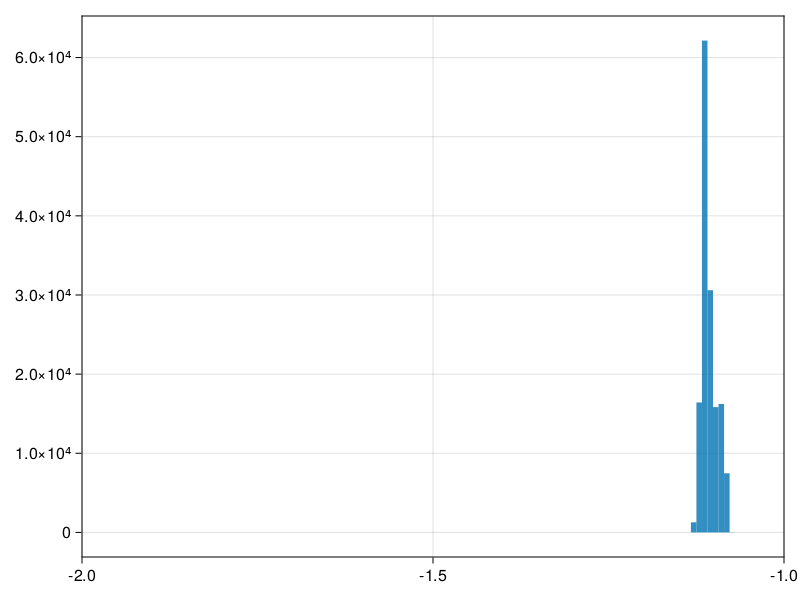

In [923]:
data_histogram(x_data[1][1,:],xlims=(-2,-1))

In [945]:
gm = classify_by_gmm(1,x_data[1]);

In [946]:
weights(gm)

1-element Vector{Float64}:
 1.0

In [947]:
alpha_threshold = 0.15

0.15

In [949]:
Σ = covars(gm)[weights(gm).>alpha_threshold,:];
xm = transpose(means(gm)[weights(gm).>alpha_threshold,:])

9×1 transpose(::Matrix{Float64}) with eltype Float64:
 -1.106292346671319
  0.49968684954153525
  1.209552653555093
 -0.814289644328484
  0.6943095538885321
  0.9328096011819234
  1.4970434756974205
  0.2465902823027045
  0.665029569057863

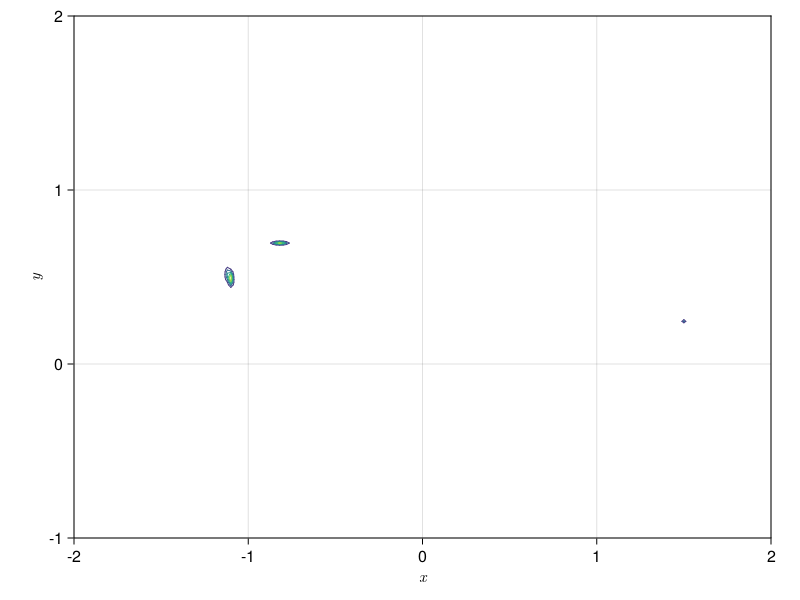

In [956]:
best_comp = 1;
plot_vorticity(xm[:,best_comp],Σ[best_comp],obs,xlims=(-2,2),ylims=(-1,2))

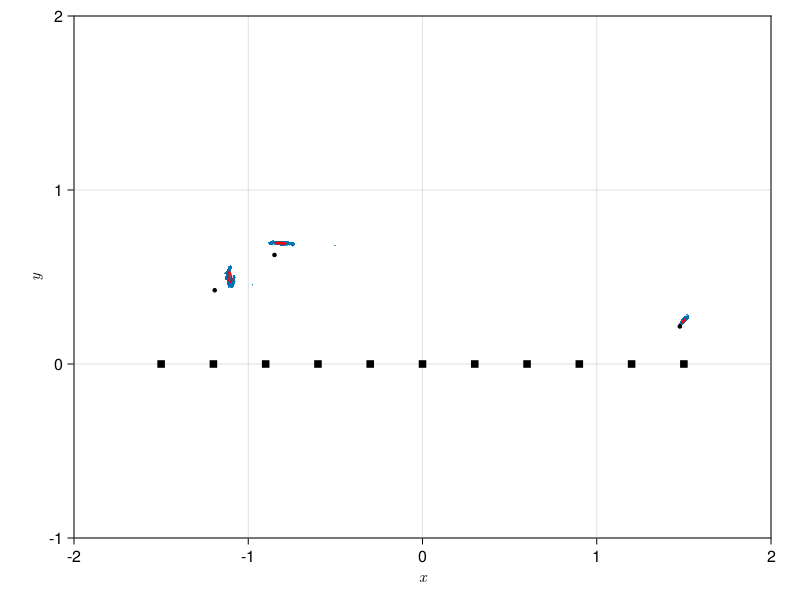

In [1008]:
f = Figure()
ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
show_vortex_samples!(ax,x_data[1],obs,ylims=(-1,2))
vortex_ellipses!(ax,xm[:,1],Σ[1],obs)
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=5,color=:black,strokewidth=1)
plot_sensors!(ax,obs)
f

#### Plotting the basic data

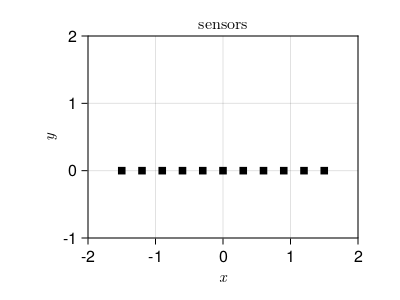

In [1005]:
f = Figure(;resolution=(400,300))
ga = f[1, 1]

axleft = Axis(ga;xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

#save("basicdata-3sensor.pdf",f)

f

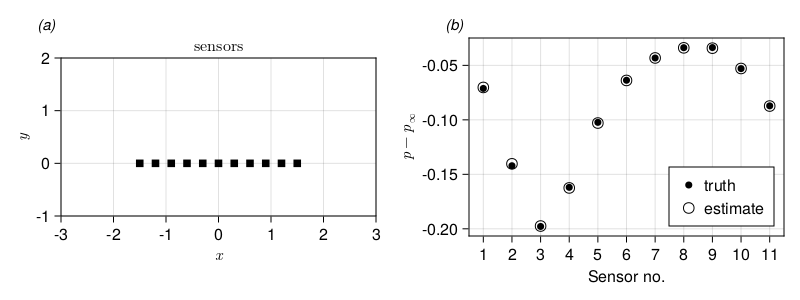

In [1006]:
f = Figure(;resolution=(800,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()

axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-3,3,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty")
plot_sensor_data!(axcenter,ystar,xm[:,1],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))

for (label, layout) in zip(["(a)", "(b)"], [ga, gb])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("basicdata-1vortex-3sensor.pdf",f)

f

#### Plotting the pressure

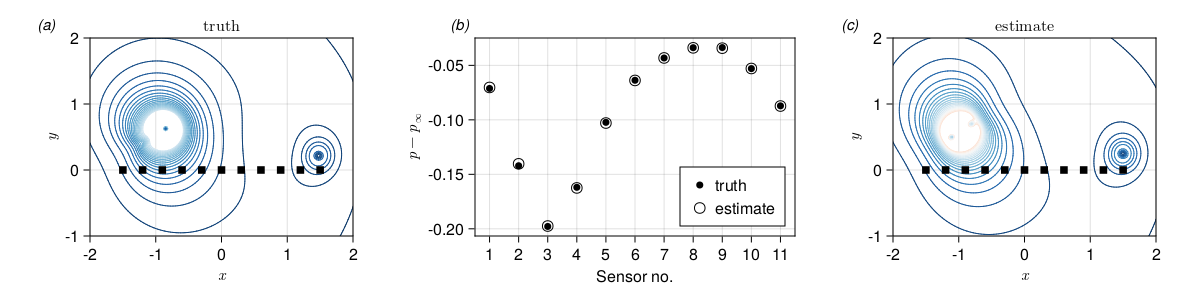

In [1002]:
l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
compute_and_plot_pressure_field!(axleft,x_true,obs)
compute_and_plot_pressure_field!(axright,xm[:,1],obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
plot_sensor_data!(axcenter,ystar,xm[:,1],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("pressure-1vortex-1truth-3sensor-case0.pdf",f)

f